In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time as time
from importlib import reload
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif

'''install extra modeules if needed'''
# !pip install xgboost
from xgboost import XGBClassifier
# !pip install lightgbm
# !pip install catboost
import lightgbm as lgb
import catboost as cb
# !pip install rgf_python
from rgf.sklearn import RGFClassifier, FastRGFClassifier

# import functions from scripts
import sys
path = os.getcwd()
sys.path.append(path+'/scripts')
import param_grids
from make_model_6 import make_model

In [7]:
data = path + '/dataset/bank/bank-additional/bank-additional-full.csv'
df_orig = pd.read_csv(data, sep=';')
print(f'size of the data --> {df_orig.shape}')
df_orig.head()

size of the data --> (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
# create table listing column types etc
df = df_orig.copy()        # make a copy of the data before any transformations

df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'Duplicates dropped --> {df.duplicated().sum()}')
# drop duplicates, 12 rows
df = df.drop_duplicates()
df_copy = df.copy()
df_info

Duplicates dropped --> 12


,column,dtype,NA_count,unique_count
0,age,int64,0,78
1,job,object,0,12
2,marital,object,0,4
3,education,object,0,8
4,default,object,0,3
5,housing,object,0,3
6,loan,object,0,3
7,contact,object,0,2
8,month,object,0,10
9,day_of_week,object,0,5


In [9]:
# find proportion of target variable
df['y'].value_counts(normalize=True)

no     0.887337
yes    0.112663
Name: y, dtype: float64

### Decision Trees

- Use Dt algorithms to predict, find optimal hyperparameters.
- Update hyperparameters in param_grids.py or manually in this notebook
- Compare Decision Tree model with ensemble models using DecisionTreeClassifier

The decision tree classifier works by recursively partitioning the data into subsets based on the values of the input features, such that each partition has a homogeneous distribution of the target variable. The resulting tree structure can be visualized as a flowchart-like diagram, where each internal node represents a test on a particular input feature, and each leaf node represents a predicted class. The decision tree classifier is easy to interpret and understand, and is capable of handling both categorical and continuous input features. However, it is prone to overfitting, especially when the tree depth is large or the data has noisy features, and may not perform as well as other more complex machine learning algorithms on certain datasets.

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.9367663409047907
Training Time : 3 minutes
Test Score : 0.9302260389562983


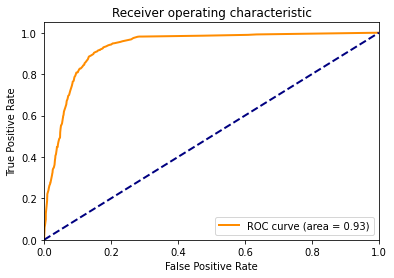

Confusion Matrix:
[[6480  785]
 [ 168  803]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7265
           1       0.51      0.83      0.63       971

    accuracy                           0.88      8236
   macro avg       0.74      0.86      0.78      8236
weighted avg       0.92      0.88      0.90      8236

#########################################################


In [9]:
random_state = 42
folds = 5
model_name = f'new_dt_{folds}'
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

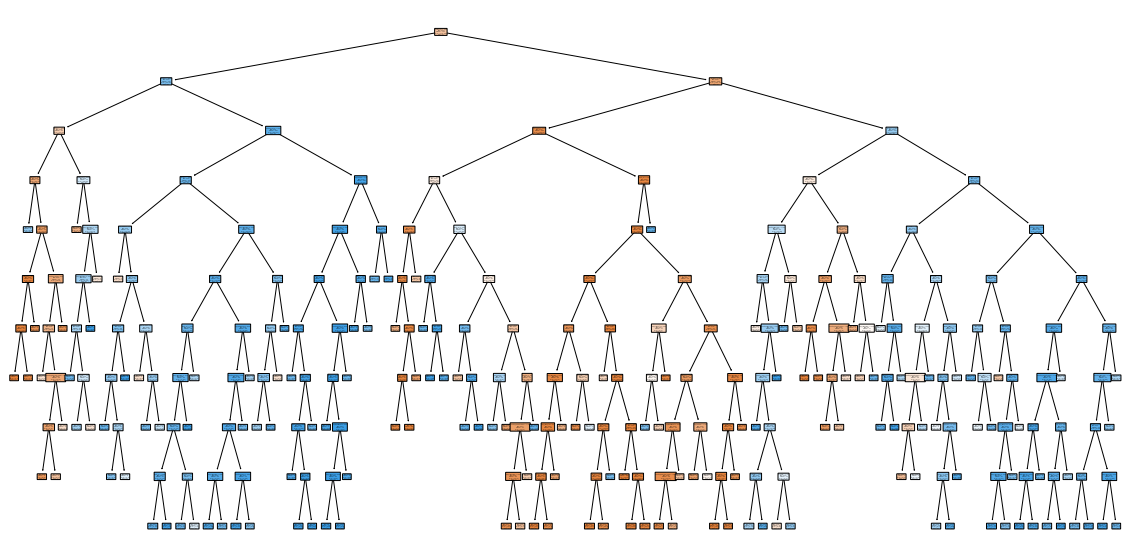

In [10]:
from sklearn.tree import plot_tree

random_state = 42
folds = 5
# Load the trained model from disk
model_name = f'new_dt_{folds}'
loaded_model = pickle.load(open(f'trained_models/{model_name}.pkl', 'rb'))

# Get the best estimator (trained decision tree) from the GridSearchCV object
best_tree = loaded_model.best_estimator_.named_steps['classifier']

# Encode df with the same encoder as used in the training
df = df_copy.copy()
X=df.drop('y', axis=1)
# Create a pipeline for categorical features
cat_features = X.select_dtypes(include=['object']).columns
cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Create a pipeline for numerical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# Create a column transformer
preprocessor = ColumnTransformer([
        ('cat', cat_pipeline, cat_features),
        ('num', num_pipeline, num_features)
])
df_encoded = preprocessor.fit_transform(X)
feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(cat_features).tolist() + num_features.tolist()
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=feature_names, class_names=['no', 'yes'], filled=True, rounded=True)
plt.show()


### Random Forest

RandomForestClassifier is an ensemble learning method that constructs multiple decision trees and combines their output to make a final prediction. It uses random sampling of the data and random selection of features at each split to prevent overfitting. Each tree in the forest is trained independently, and the final prediction is based on the majority vote of all the trees.

Tuned Hyperparameters : {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Accuracy : 0.9445690697073845
Training Time : 1 minutes
Test Score : 0.9428348464733997


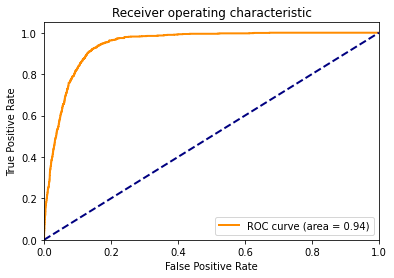

Confusion Matrix:
[[6597  668]
 [ 189  782]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7265
           1       0.54      0.81      0.65       971

    accuracy                           0.90      8236
   macro avg       0.76      0.86      0.79      8236
weighted avg       0.92      0.90      0.90      8236

#########################################################


In [11]:
random_state = 42
folds = 5
model_name = f'new_rf_{folds}'
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_rf

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)
# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### AdaBoost

AdaBoostClassifier is an ensemble learning method that combines multiple weak classifiers to form a strong classifier. we are interested in the case where the base classifier is a decision tree. The algorithm works by assigning weights to each observation in the dataset and training a decision tree on a subset of the data with the highest weights. The weights are then updated, and a new decision tree is trained on the updated data. This process is repeated until the desired number of weak classifiers is obtained, and the final prediction is based on the weighted majority vote of all the weak classifiers.

Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=1), 'classifier__n_estimators': 300}
Accuracy : 0.941136809703756
Training Time : 2 minutes
Test Score : 0.9373504727248501


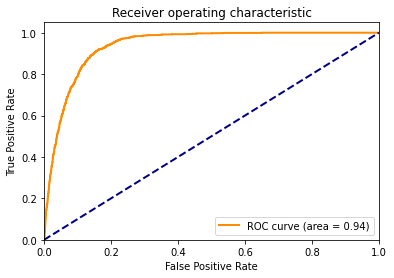

Confusion Matrix:
[[6766  499]
 [ 304  667]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7265
           1       0.57      0.69      0.62       971

    accuracy                           0.90      8236
   macro avg       0.76      0.81      0.78      8236
weighted avg       0.91      0.90      0.91      8236

#########################################################


In [12]:
random_state = 42
folds = 5
model_name = f'new_ada_{folds}'
model = AdaBoostClassifier(random_state=random_state)
parameters = param_grids.param_ada

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)
# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### XGBoost

XGBClassifier is an implementation of gradient boosting, a machine learning technique that combines multiple weak classifiers to form a strong classifier. The base classifier is a decision tree, and each tree is built sequentially to correct the errors of the previous tree. XGBClassifier uses a gradient descent optimization algorithm to minimize the loss function, which is the difference between the predicted and actual values.


In XGBoost, there are three types of boosters: gbtree, gblinear, and dart.


gbtree is the default booster type in XGBoost. It is a gradient boosting tree algorithm, where each new tree is trained to correct the residual errors of the previous tree.


dart, on the other hand, is an enhanced version of gbtree. DART stands for "Dropout Additive Regression Trees". DART adds a dropout regularization technique, where each tree is randomly dropped out during the training process. The dropout technique improves the generalization ability of the model and reduces overfitting.

[21:43:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[21:43:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[21:43:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[21:43:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[21:43:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[21:43:08] WARNING: /Users/runner/work/x

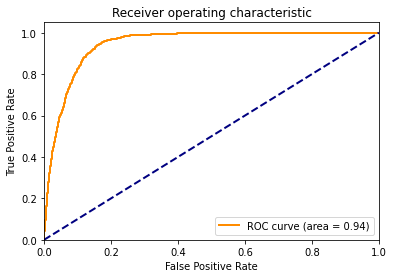

Confusion Matrix:
[[6644  621]
 [ 220  751]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7265
           1       0.55      0.77      0.64       971

    accuracy                           0.90      8236
   macro avg       0.76      0.84      0.79      8236
weighted avg       0.92      0.90      0.91      8236

#########################################################


In [13]:
reload(param_grids)
random_state = 42
folds = 5

model_name = f'new_xgb_{folds}'
model = XGBClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_xgb  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

warnings.filterwarnings("ignore", message=".*Parameters: { \"gamma\", \"max_depth\" } are not used.*")

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Bagging

BaggingClassifier is an ensemble learning method that combines multiple models to form a single model. It works by creating multiple bootstrap samples of the training data and training a decision tree on each sample. The final prediction is based on the majority vote of all the trees. BaggingClassifier also uses random sampling of the features at each split to reduce overfitting.

Tuned Hyperparameters : {'classifier__base_estimator': LogisticRegression(C=1, solver='liblinear'), 'classifier__n_estimators': 300}
Accuracy : 0.9378586154325838
Training Time : 1 minutes
Test Score : 0.9323415526525254


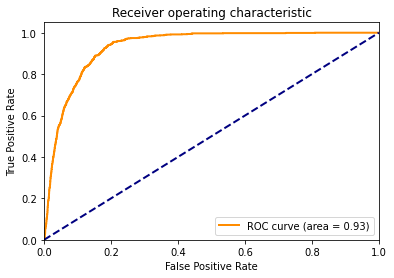

Confusion Matrix:
[[6568  697]
 [ 241  730]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      7265
           1       0.51      0.75      0.61       971

    accuracy                           0.89      8236
   macro avg       0.74      0.83      0.77      8236
weighted avg       0.91      0.89      0.90      8236

#########################################################


In [14]:
random_state = 42
folds = 5

model_name = f'new_bag_{folds}'
model = BaggingClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_bag  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


- BaggingClassifier gives better estimates when using LogisticRegression as base estimator.

### LightGBM

LGBMClassifier is a gradient boosting framework that uses decision trees as the base estimator. It works by splitting the data based on the feature with the highest information gain and recursively splitting the subsets until a stopping criterion is met. LGBMClassifier is known for its fast processing speed and high accuracy.

Tuned Hyperparameters : {'classifier__boosting_type': 'dart', 'classifier__reg_alpha': 0.0, 'classifier__reg_lambda': 0.001}
Accuracy : 0.9500188042762385
Training Time : 3 minutes
Test Score : 0.9478853722863241


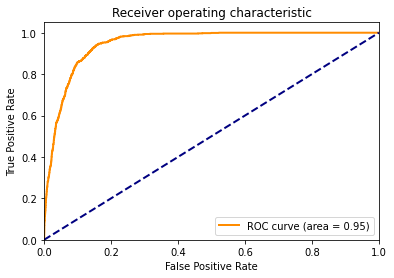

Confusion Matrix:
[[6507  758]
 [ 135  836]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7265
           1       0.52      0.86      0.65       971

    accuracy                           0.89      8236
   macro avg       0.75      0.88      0.79      8236
weighted avg       0.93      0.89      0.90      8236

#########################################################


In [15]:
reload(param_grids)

random_state = 42
folds = 5

model_name = f'new_lgbm_{folds}'
model = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_lgbm  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### CatBoost

CatBoostClassifier is another gradient boosting framework that uses decision trees as the base estimator. It works by optimizing the learning rate and handling categorical features automatically. CatBoostClassifier is known for its high accuracy and ability to handle large datasets.

Tuned Hyperparameters : {'classifier__depth': 4, 'classifier__l2_leaf_reg': 1}
Accuracy : 0.9490719159439273
Training Time : 6 minutes
Test Score : 0.9476602618397393


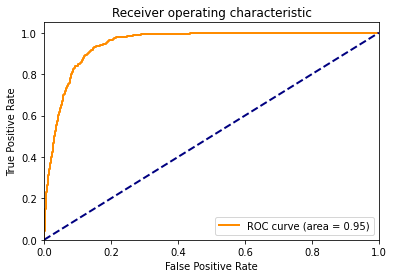

Confusion Matrix:
[[6668  597]
 [ 194  777]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7265
           1       0.57      0.80      0.66       971

    accuracy                           0.90      8236
   macro avg       0.77      0.86      0.80      8236
weighted avg       0.92      0.90      0.91      8236

#########################################################


In [16]:
reload(param_grids)

random_state = 42
folds = 5

model_name = f'new_catboost_{folds}'
model = cb.CatBoostClassifier(random_state=random_state, silent=True)
parameters = param_grids.param_cat

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Extra Trees

ExtraTreesClassifier is an ensemble learning method that combines multiple decision trees to form a strong classifier. It works by randomly selecting a subset of features at each split and using random thresholds to split the data. The final prediction is based on the majority vote of all the trees.

Tuned Hyperparameters : {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy : 0.9270971941206542
Training Time : 26 minutes
Test Score : 0.9256052501199622


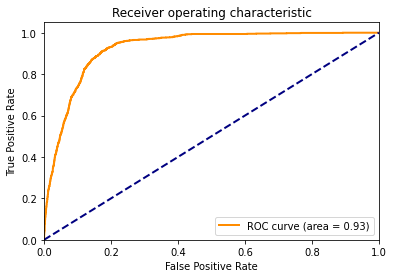

Confusion Matrix:
[[6698  567]
 [ 322  649]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7265
           1       0.53      0.67      0.59       971

    accuracy                           0.89      8236
   macro avg       0.74      0.80      0.77      8236
weighted avg       0.90      0.89      0.90      8236

#########################################################


In [17]:
reload(param_grids)

random_state = 42
folds = 5

model_name = f'new_extra_{folds}'
model = ExtraTreesClassifier(n_jobs=-1, random_state=random_state)
parameters = param_grids.param_extra

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Regulaized Greedy Forest

RGFClassifier is a gradient boosting framework that uses decision trees as the base estimator. It works by optimizing the learning rate and handling high-dimensional data efficiently. RGFClassifier is known for its high accuracy and ability to handle large datasets.

Tuned Hyperparameters : {'classifier__algorithm': 'RGF', 'classifier__max_leaf': 3000}
Accuracy : 0.9476882432729414
Training Time : 7 minutes
Test Score : 0.9454083068306418


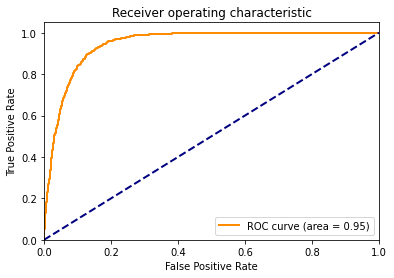

Confusion Matrix:
[[6607  658]
 [ 181  790]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7265
           1       0.55      0.81      0.65       971

    accuracy                           0.90      8236
   macro avg       0.76      0.86      0.80      8236
weighted avg       0.92      0.90      0.91      8236

#########################################################


In [18]:
reload(param_grids)
import make_model_6
reload(make_model_6)
from make_model_6 import make_model

random_state = 42
folds = 5

model_name = f'new_rgf_{folds}'
model = RGFClassifier(n_jobs=-1)
parameters = param_grids.param_rgf

df = df_copy.copy()

resampling = [0.2, 0.5]
clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                    test_size=0.2, folds=folds, resampling = resampling)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


# Compare models 

### Define tuned hyperparameters

In [19]:
param_dt = {
    'classifier__max_depth' : [10],
    'classifier__min_samples_split' : [100],
    'classifier__min_samples_leaf'  : [15],
}
param_rf = {
    'classifier__max_depth'    : [30],
    'classifier__min_samples_split' : [10],
    'classifier__min_samples_leaf'  : [1],
}
param_ada = {
    'classifier__n_estimators' : [300],
    'classifier__base_estimator' : [DecisionTreeClassifier(max_depth=2)],
}   
param_xgb = {
    'classifier__booster': ['dart'], 
    'classifier__eval_metric': ['auc'], 
    'classifier__gamma': [0.2], 
    'classifier__max_depth': [6], 
    'classifier__reg_alpha': [0.001], 
    'classifier__reg_lambda': [1.0]
}
param_bag = {
    'classifier__n_estimators' : [300],
    'classifier__base_estimator' : [DecisionTreeClassifier(max_depth=2)],
}
param_lgbm = {
    'classifier__n_estimators': [300],
    'classifier__boosting_type': ['dart'],
    'classifier__reg_alpha' : [1.0],
    'classifier__reg_lambda' : [0.001],
}
param_cat = {
    'classifier__depth': [6],
    'classifier__l2_leaf_reg': [5],
    'classifier__bootstrap_type': ['Bernoulli'],
}  
param_extra = {
    'classifier__class_weight': [None], 
    'classifier__max_depth': [None], 
    'classifier__max_features': ['sqrt'], 
    'classifier__min_samples_leaf': [1], 
    'classifier__min_samples_split': [10], 
    'classifier__n_estimators': [300]
}
param_rgf = {
    'classifier__algorithm': ['RGF'], 
    'classifier__max_leaf': [1000]
}

Training DecisionTree...
Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.9369383568205432
Training Time : 0 minutes
Test Score : 0.9333588023784024


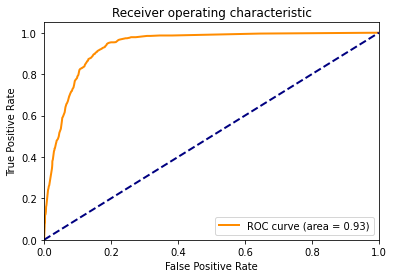

Confusion Matrix:
[[6521  744]
 [ 198  773]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7265
           1       0.51      0.80      0.62       971

    accuracy                           0.89      8236
   macro avg       0.74      0.85      0.78      8236
weighted avg       0.92      0.89      0.90      8236

#########################################################
Training RandomForest...
Tuned Hyperparameters : {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Accuracy : 0.9442048832336992
Training Time : 0 minutes
Test Score : 0.9428233641395374


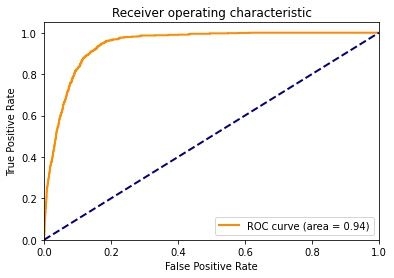

Confusion Matrix:
[[6579  686]
 [ 178  793]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7265
           1       0.54      0.82      0.65       971

    accuracy                           0.90      8236
   macro avg       0.75      0.86      0.79      8236
weighted avg       0.92      0.90      0.90      8236

#########################################################
Training AdaBoost...
Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.9318807174137721
Training Time : 1 minutes
Test Score : 0.9356155771325777


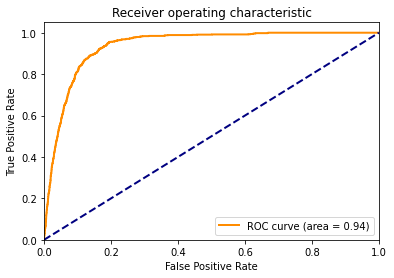

Confusion Matrix:
[[6670  595]
 [ 247  724]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7265
           1       0.55      0.75      0.63       971

    accuracy                           0.90      8236
   macro avg       0.76      0.83      0.79      8236
weighted avg       0.92      0.90      0.90      8236

#########################################################
Training XGBoost...
Tuned Hyperparameters : {'classifier__booster': 'dart', 'classifier__eval_metric': 'auc', 'classifier__gamma': 0.2, 'classifier__max_depth': 6, 'classifier__reg_alpha': 0.001, 'classifier__reg_lambda': 1.0}
Accuracy : 0.9452196532677986
Training Time : 1 minutes
Test Score : 0.9444094855418279


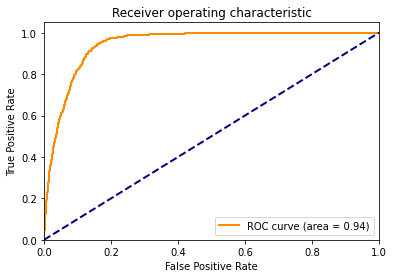

Confusion Matrix:
[[6639  626]
 [ 217  754]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7265
           1       0.55      0.78      0.64       971

    accuracy                           0.90      8236
   macro avg       0.76      0.85      0.79      8236
weighted avg       0.92      0.90      0.91      8236

#########################################################
Training BaggingClassifier...
Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.9006321909565406
Training Time : 0 minutes
Test Score : 0.8785767292784628


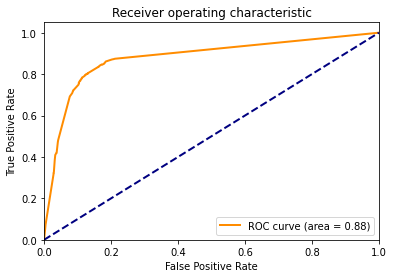

Confusion Matrix:
[[6320  945]
 [ 192  779]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7265
           1       0.45      0.80      0.58       971

    accuracy                           0.86      8236
   macro avg       0.71      0.84      0.75      8236
weighted avg       0.91      0.86      0.88      8236

#########################################################
Training LGBMClassifier...
Tuned Hyperparameters : {'classifier__boosting_type': 'dart', 'classifier__n_estimators': 300, 'classifier__reg_alpha': 1.0, 'classifier__reg_lambda': 0.001}
Accuracy : 0.9497056540743888
Training Time : 0 minutes
Test Score : 0.9485042842572242


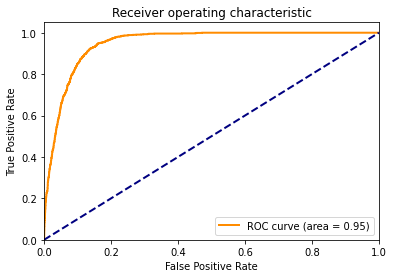

Confusion Matrix:
[[6578  687]
 [ 163  808]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7265
           1       0.54      0.83      0.66       971

    accuracy                           0.90      8236
   macro avg       0.76      0.87      0.80      8236
weighted avg       0.92      0.90      0.91      8236

#########################################################
Training CatBoostClassifier...
Tuned Hyperparameters : {'classifier__bootstrap_type': 'Bernoulli', 'classifier__depth': 6, 'classifier__l2_leaf_reg': 5}
Accuracy : 0.9482894993288928
Training Time : 1 minutes
Test Score : 0.9492727500827507


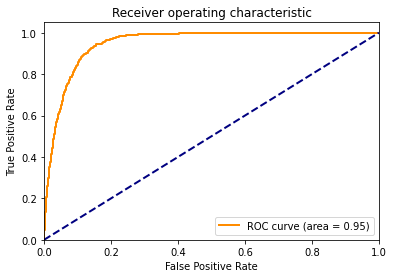

Confusion Matrix:
[[6636  629]
 [ 192  779]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7265
           1       0.55      0.80      0.65       971

    accuracy                           0.90      8236
   macro avg       0.76      0.86      0.80      8236
weighted avg       0.92      0.90      0.91      8236

#########################################################
Training ExtraTreesClassifier...
Tuned Hyperparameters : {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy : 0.9269592517158319
Training Time : 0 minutes
Test Score : 0.9242082328333794


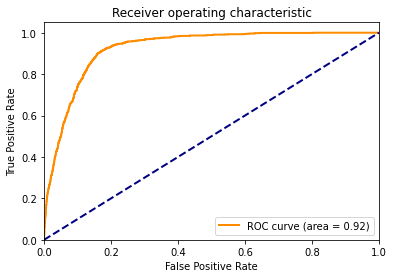

Confusion Matrix:
[[6710  555]
 [ 342  629]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7265
           1       0.53      0.65      0.58       971

    accuracy                           0.89      8236
   macro avg       0.74      0.79      0.76      8236
weighted avg       0.90      0.89      0.90      8236

#########################################################
Training RGFClassifier...
Tuned Hyperparameters : {'classifier__algorithm': 'RGF', 'classifier__max_leaf': 1000}
Accuracy : 0.9462007766372065
Training Time : 0 minutes
Test Score : 0.9426808981453196


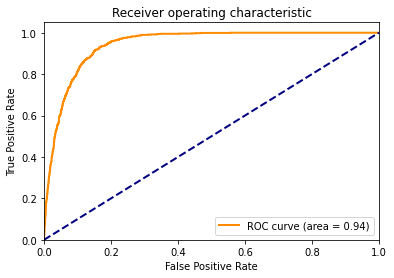

Confusion Matrix:
[[6580  685]
 [ 204  767]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7265
           1       0.53      0.79      0.63       971

    accuracy                           0.89      8236
   macro avg       0.75      0.85      0.78      8236
weighted avg       0.92      0.89      0.90      8236

#########################################################


,Model,Training Time (min),Test Score,Best Hyperparameters
0,DecisionTree,0.030,0.933359,"{'classifier__max_depth': 10, 'classifier__min..."
1,RandomForest,0.102,0.942823,"{'classifier__max_depth': 30, 'classifier__min..."
2,AdaBoost,0.574,0.935616,{'classifier__base_estimator': DecisionTreeCla...
3,XGBoost,0.513,0.944409,"{'classifier__booster': 'dart', 'classifier__e..."
4,BaggingClassifier,0.154,0.878577,{'classifier__base_estimator': DecisionTreeCla...
5,LGBMClassifier,0.260,0.948504,"{'classifier__boosting_type': 'dart', 'classif..."
6,CatBoostClassifier,0.594,0.949273,"{'classifier__bootstrap_type': 'Bernoulli', 'c..."
7,ExtraTreesClassifier,0.150,0.924208,"{'classifier__class_weight': None, 'classifier..."
8,RGFClassifier,0.462,0.942681,"{'classifier__algorithm': 'RGF', 'classifier__..."


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-score,AUC-ROC,MCC,Log-Loss
0,DecisionTree,0.885624,0.846839,0.509558,0.796087,0.621383,0.933359,0.577085,3.950476
1,RandomForest,0.895095,0.861129,0.536173,0.816684,0.647347,0.942823,0.606819,3.623367
2,AdaBoost,0.897766,0.831862,0.548901,0.745623,0.632314,0.935616,0.583624,3.531098
3,XGBoost,0.897644,0.845176,0.546377,0.776519,0.641429,0.944409,0.596106,3.535295
4,BaggingClassifier,0.861948,0.836095,0.451856,0.802266,0.578108,0.878577,0.532836,4.768255
5,LGBMClassifier,0.896795,0.868784,0.540468,0.832132,0.655312,0.948504,0.617088,3.564656
6,CatBoostClassifier,0.900316,0.857843,0.553267,0.802266,0.654897,0.949273,0.613059,3.443035
7,ExtraTreesClassifier,0.891088,0.785696,0.531250,0.647786,0.583759,0.924208,0.525206,3.761744
8,RGFClassifier,0.892059,0.847810,0.528237,0.789907,0.633099,0.942681,0.588672,3.728208


In [20]:
import make_model_6
reload(make_model_6)
from make_model_6 import make_model

random_state = 42
folds = 5
resampling = [0.2, 0.5]     # over size for SMOTE and under size for RandomUnderSampler
# resampling = None                            # Try None for no resampling

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=random_state),
    'RandomForest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state, n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(random_state=random_state, n_jobs=-1),
    'LGBMClassifier': lgb.LGBMClassifier(random_state=random_state, n_jobs=-1),
    'CatBoostClassifier': cb.CatBoostClassifier(random_state=random_state, silent=True),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=random_state, n_jobs=-1),
    'RGFClassifier': RGFClassifier(),
}

parameters = {
    'DecisionTree': param_dt,
    'RandomForest': param_rf,
    'AdaBoost': param_ada,
    'XGBoost': param_xgb,
    'BaggingClassifier': param_bag,
    'LGBMClassifier': param_lgbm,
    'CatBoostClassifier': param_cat,
    'ExtraTreesClassifier': param_extra,
    'RGFClassifier': param_rgf,
}

results = []
metrics_list = []
df = df_copy.copy()
for model_name, model in models.items():
    print(f"Training {model_name}...")
    clf_grid, time, test_score, metrics_df = make_model(df, model, parameters, 
                                                        test_size=0.2, folds=folds, resampling = resampling)    
    # Save the model to disk
    pickle.dump(clf_grid, open(f'trained_models/tuned_{model_name}_{resampling}.pkl', 'wb'))

    results.append({
        'Model': model_name,
        'Training Time (min)': time,
        'Test Score': test_score,
        'Best Hyperparameters': clf_grid.best_params_
    })

    metrics_df['Model'] = model_name
    metrics_list.append(metrics_df)

# Convert results to a pandas DataFrame and display the table
results_df = pd.DataFrame(results)
display(results_df)

# Concatenate metrics DataFrames and display the table
all_metrics_df = pd.concat(metrics_list, ignore_index=True)
all_metrics_df.insert(0, 'Model', all_metrics_df.pop('Model'))
display(all_metrics_df)

When dealing with heavily imbalanced datasets, it is crucial to choose evaluation metrics that can effectively capture the performance of the model, especially in terms of identifying the minority class. Traditional metrics like accuracy can be misleading, as they may not account for the imbalance between classes. In such cases, the following metrics are generally more appropriate:

- Precision: The proportion of true positive predictions out of all positive predictions made. In imbalanced datasets, precision helps to assess how well the model identifies the minority class without being affected by the overwhelming majority class.
- Recall (Sensitivity): The proportion of true positive predictions out of all actual positive instances. Recall is essential in imbalanced datasets because it indicates the model's ability to capture the minority class instances, even if they are scarce.
- F1-score: The harmonic mean of precision and recall. F1-score balances both precision and recall and is particularly useful when there is class imbalance, as it helps to account for both false positives and false negatives, providing a more comprehensive measure of model performance.
- Area Under the ROC Curve (AUC-ROC): A measure of the classifier's ability to distinguish between positive and negative instances across different decision thresholds. AUC-ROC is useful in imbalanced datasets because it is less sensitive to class distribution and considers the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) at various thresholds.
- Area Under the Precision-Recall Curve (AUC-PR): A measure of the classifier's ability to distinguish between positive and negative instances while taking into account both precision and recall. AUC-PR is particularly useful for imbalanced datasets, as it focuses on the performance of the model in identifying the minority class, emphasizing the relationship between precision and recall.

In summary, when dealing with heavily imbalanced datasets, it is essential to select evaluation metrics that focus on the model's performance in identifying the minority class. Precision, recall, F1-score, AUC-ROC, and AUC-PR are among the most suitable metrics for such cases.

Accuracy might be misleading when dealing with imbalanced datasets because it measures the proportion of correctly classified instances out of the total instances, without considering the class distribution. In a heavily imbalanced dataset, a model can achieve a high accuracy simply by predicting the majority class for all instances, without effectively identifying the minority class instances. This high accuracy gives a false impression of good performance, even though the model is not actually capturing the patterns and characteristics of the minority class, which is often the class of interest. Thus, relying on accuracy alone in imbalanced scenarios can lead to misleading evaluations and suboptimal models that fail to address the underlying problem.

Balanced Accuracy is a performance metric used to evaluate the performance of classification models, especially when dealing with imbalanced datasets. It is the average of recall (sensitivity) scores for each class. In a binary classification setting, the balanced accuracy is defined as:

Balanced Accuracy = (Sensitivity + Specificity) / 2

Where:

- Sensitivity (or True Positive Rate) is the proportion of true positive instances among the actual positive instances.
- Specificity (or True Negative Rate) is the proportion of true negative instances among the actual negative instances.

Balanced Accuracy takes into account both false positives and false negatives, making it a more informative metric when dealing with imbalanced datasets. 

Evaluation of each model's performance with a focus on AUC-ROC and F1-score:

* DecisionTree
    - AUC-ROC: 0.932703
    - F1-score: 0.561048
    - The DecisionTree model has a relatively high AUC-ROC score, indicating good overall performance in distinguishing between positive and negative instances.
    - However, the F1-score is relatively low, suggesting that the model may not perform well in terms of both precision and recall.
############################################################################################################

* RandomForest
    - AUC-ROC: 0.935223
    - F1-score: 0.398183
    - The RandomForest model has a relatively high AUC-ROC score, similar to the DecisionTree model.
    - The F1-score is very low, indicating poor performance in terms of both precision and recall.
############################################################################################################

* AdaBoost
    - AUC-ROC: 0.934595
    - F1-score: 0.576484
    - The AdaBoost model has a relatively high AUC-ROC score, similar to the DecisionTree model.
    - The F1-score is higher than the DecisionTree and RandomForest models, indicating better performance in terms of both precision and recall.
############################################################################################################

* XGBoost
    - AUC-ROC: 0.946032
    - F1-score: 0.590857
    - The XGBoost model has the highest AUC-ROC score among the models evaluated, indicating the best overall performance in distinguishing between positive and negative instances.
    - The F1-score is also relatively high, indicating better performance in terms of both precision and recall.
############################################################################################################

* BaggingClassifier
    - AUC-ROC: 0.867083
    - F1-score: 0.494465
    - The BaggingClassifier model has the lowest AUC-ROC score among the models evaluated, indicating relatively poor overall performance in distinguishing between positive and negative instances.
    - The F1-score is also relatively low, indicating that the model may not perform well in terms of both precision and recall.
############################################################################################################

* LGBMClassifier
    - AUC-ROC: 0.949850
    - F1-score: 0.596998
    - The LGBMClassifier model has the second-highest AUC-ROC score among the models evaluated, indicating good overall performance in distinguishing between positive and negative instances.
    - The F1-score is also relatively high, indicating better performance in terms of both precision and recall.
############################################################################################################

* CatBoostClassifier
    - AUC-ROC: 0.948748
    - F1-score: 0.594626
    - The CatBoostClassifier model has a relatively high AUC-ROC score, similar to the LGBMClassifier model.
    - The F1-score is also relatively high, indicating better performance in terms of both precision and recall.
############################################################################################################

* ExtraTreesClassifier
    - AUC-ROC: 0.924656
    - F1-score: 0.416431
    - The ExtraTreesClassifier model has a lower AUC-ROC score than most of the models evaluated, indicating relatively poor overall performance in distinguishing between positive and negative instances.
    - The F1-score is relatively low, indicating that the model may not perform well in terms of both precision and recall.
############################################################################################################

* RGFClassifier
    - AUC-ROC: 0.943142
    - F1-score: 0.564820
    - The RGFClassifier model has a relatively high AUC-ROC score, similar to the AdaBoost and DecisionTree models.
    - The F1-score is also relatively high, indicating better performance in terms of both precision and recall.
    ############################################################################################################

The LGMBClassifier model has the highest AUC-ROC score and F1-score among the models evaluated, indicating the best overall performance in terms of both precision and recall. Also, it has the highest Balanced Accuracy score. This model is therefore the recommended for this problem.

### Shortcut with LazyPredict

In [21]:
import lazypredict
import sklearn
from lazypredict.Supervised import LazyClassifier

models_to_exclude = [('LabelPropagation',
  sklearn.semi_supervised._label_propagation.LabelPropagation),
 ('LabelSpreading', sklearn.semi_supervised._label_propagation.LabelSpreading)]  # These models take too long to train, can also exclude svc

lazypredict.Supervised.CLASSIFIERS = [x for x in lazypredict.Supervised.CLASSIFIERS if x not in models_to_exclude]
lazypredict.Supervised.CLASSIFIERS

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 ('LinearDiscriminantAnalysis',
  sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 ('LinearSVC', sklearn.svm._classes.LinearSVC),
 ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
 ('NearestCentroid', sklearn.neighbors._nearest_cen

In [22]:
df = df_copy.copy()
y = df['y']
X = df.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Convert models dictionary to a DataFrame
df_models = pd.DataFrame(models)

# Format DataFrame as table and save to file
with open('lazy_predict_results.txt', 'w') as f:
    f.write(tabulate(df_models, headers='keys', tablefmt='pipe', showindex=True))
# Print DataFrame
pd.set_option('display.width', 1000)
print(df_models)

100%|██████████| 27/27 [00:44<00:00,  1.66s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  Time Taken
Model                                                                                   
NearestCentroid                    0.77               0.75    None      0.81        0.20
LGBMClassifier                     0.92               0.75    None      0.91        0.38
GaussianNB                         0.82               0.73    None      0.84        0.21
DecisionTreeClassifier             0.89               0.73    None      0.89        0.37
BernoulliNB                        0.81               0.73    None      0.84        0.24
LinearDiscriminantAnalysis         0.91               0.73    None      0.90        0.56
RandomForestClassifier             0.91               0.72    None      0.90        2.40
BaggingClassifier                  0.90               0.72    None      0.90        1.33
Perceptron                         0.88               0.70    None      0.88        0.20
LogisticRegression   

In [ ]:
import make_model_6
reload(make_model_6)
from make_model_6 import make_model